In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.tree as tree
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from collections import Counter
import re

# <u>שלב 2</u>

## איחוד הקבצים

In [2]:
import pandas as pd
import os

# יצירת רשימה לאחסון הקבצים
files = ['expedia_hotels_ny5.csv', 'expedia_hotels_ny3.csv' , 'expedia_hotels_ny4.csv']

# יצירת רשימה ריקה לאחסון כל השורות
all_rows = []

# לולאה על כל קובץ ברשימת הקבצים
for file in files:
    # קריאת הקובץ
    df = pd.read_csv(file)
    # הוספת עמודה עם שם הקובץ
    df['source_file'] = os.path.basename(file)
    # ניקוי סימון שח מעמודת מחיר ומחיר לפני הנחה
    df['original_price'] = df['original_price'].replace('[$,]', '', regex=True).astype(float)
    #df['original_price'] = df['original_price'].fillna(0).astype(int)  # Handle NaNs before converting to int
    df['current_price'] = df['current_price'].replace('[$,]', '', regex=True).astype(float)
    df['breakfast'] = df['breakfast'].replace('Breakfast included', 'Yes')

    # הוספת השורות לרשימה
    all_rows.append(df)

# איחוד כל השורות לטבלה אחת
data = pd.concat(all_rows, ignore_index=True)

# יצירת קובץ CSV חדש עם הנתונים המאוחדים
data.to_csv('merged_expedia.csv', index=False)

# Exploration

In [3]:
data.head()

,name,neighborhood,current_price,original_price,reviews_desc,num_reviews,breakfast,free_cancellation,rooms_left,grade,fully_refundable,reserve_now_pay_later,price_after_taxes,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,source_file
0,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN,NaN,No,No,NaN,08/07/2024,09/07/2024,1,1,07/07/2024,1,expedia_hotels_ny5.csv
1,Hyatt House Jersey City,Jersey City,227.0,252.0,Excellent,"1,306",Yes,No,8.0,8.68,No,No,265 total,08/07/2024,09/07/2024,1,1,07/07/2024,2,expedia_hotels_ny5.csv
2,Margaritaville Resort Times Square,Theater District,185.0,NaN,Wonderful,"3,670",No,No,NaN,9.29,No,No,274 total,08/07/2024,09/07/2024,1,1,07/07/2024,3,expedia_hotels_ny5.csv
3,Penny Williamsburg,Williamsburg,220.0,275.0,Exceptional,521,No,Yes,1.0,9.69,Yes,Yes,292 total,08/07/2024,09/07/2024,1,1,07/07/2024,4,expedia_hotels_ny5.csv
4,"PUBLIC, an Ian Schrager hotel",New York,329.0,NaN,Very,"2,625",No,No,NaN,8.28,No,No,427 total,08/07/2024,09/07/2024,1,1,07/07/2024,5,expedia_hotels_ny5.csv


In [4]:
data.sample()

,name,neighborhood,current_price,original_price,reviews_desc,num_reviews,breakfast,free_cancellation,rooms_left,grade,fully_refundable,reserve_now_pay_later,price_after_taxes,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,source_file
43828,Westgate New York Grand Central,New York,226.0,257.0,Wonderful,"1,704",No,No,NaN,9.09,No,No,303 total,03/08/2024,04/08/2024,29,1,05/07/2024,39,expedia_hotels_ny3.csv


In [5]:
unique_column = 'order'

# יצירת רשימת העמודות לבדיקה, מבלי לכלול את העמודה הייחודית
columns_to_check = data.columns.difference([unique_column])

# הסרת שורות כפולות
original_rows = data.shape[0]

# הסרת שורות כפולות
df_unique = data.drop_duplicates(subset=columns_to_check, keep='first')

# מספר השורות לאחר הסרת הכפילויות
new_rows = df_unique.shape[0]

# הצגת הדאטהפריים לאחר הסרת הכפילויות
print(f"\nNumber of rows removed: {original_rows - new_rows}")



Number of rows removed: 3298


In [6]:
data = df_unique

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64652 entries, 0 to 67949
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   63868 non-null  object 
 1   neighborhood           64199 non-null  object 
 2   current_price          64202 non-null  float64
 3   original_price         30415 non-null  float64
 4   reviews_desc           63696 non-null  object 
 5   num_reviews            64200 non-null  object 
 6   breakfast              64652 non-null  object 
 7   free_cancellation      64652 non-null  object 
 8   rooms_left             21923 non-null  float64
 9   grade                  64117 non-null  float64
 10  fully_refundable       64652 non-null  object 
 11  reserve_now_pay_later  64652 non-null  object 
 12  price_after_taxes      64202 non-null  object 
 13  checkin_date           64652 non-null  object 
 14  checkout_date          64652 non-null  object 
 15  TTT    

In [8]:
# טיפול בשדות של הדטה
# הפונקציה להמרת המחרוזת לתאריך
def convert_to_date(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')

# החלת הפונקציה על עמודת 'checkin_date'
data['checkin_date'] = data['checkin_date'].apply(convert_to_date)
data['checkout_date'] = data['checkout_date'].apply(convert_to_date)
data['Snapshot Date'] = data['Snapshot Date'].apply(convert_to_date)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64652 entries, 0 to 67949
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   63868 non-null  object        
 1   neighborhood           64199 non-null  object        
 2   current_price          64202 non-null  float64       
 3   original_price         30415 non-null  float64       
 4   reviews_desc           63696 non-null  object        
 5   num_reviews            64200 non-null  object        
 6   breakfast              64652 non-null  object        
 7   free_cancellation      64652 non-null  object        
 8   rooms_left             21923 non-null  float64       
 9   grade                  64117 non-null  float64       
 10  fully_refundable       64652 non-null  object        
 11  reserve_now_pay_later  64652 non-null  object        
 12  price_after_taxes      64202 non-null  object        
 13  checki

### תיקון הנתונים והמרה למשתנה נומרי

In [9]:
# Clean the 'price_after_taxes' column
data['price_after_taxes'] = data['price_after_taxes'].str.replace(r'\D', '', regex=True)

# Convert the cleaned column to numeric
data['price_after_taxes'] = pd.to_numeric(data['price_after_taxes'], errors='coerce')

# Convert 'num_reviews' column to numeric
data['num_reviews'] = data['num_reviews'].str.replace(',', '').astype(float)




In [10]:
print(data['num_reviews'].dtype)

float64


In [11]:
print(data['price_after_taxes'].dtype)

float64


In [12]:
data.head()

,name,neighborhood,current_price,original_price,reviews_desc,num_reviews,breakfast,free_cancellation,rooms_left,grade,fully_refundable,reserve_now_pay_later,price_after_taxes,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,source_file
0,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN,NaN,No,No,NaN,2024-07-08,2024-07-09,1,1,2024-07-07,1,expedia_hotels_ny5.csv
1,Hyatt House Jersey City,Jersey City,227.0,252.0,Excellent,1306.0,Yes,No,8.0,8.68,No,No,265.0,2024-07-08,2024-07-09,1,1,2024-07-07,2,expedia_hotels_ny5.csv
2,Margaritaville Resort Times Square,Theater District,185.0,NaN,Wonderful,3670.0,No,No,NaN,9.29,No,No,274.0,2024-07-08,2024-07-09,1,1,2024-07-07,3,expedia_hotels_ny5.csv
3,Penny Williamsburg,Williamsburg,220.0,275.0,Exceptional,521.0,No,Yes,1.0,9.69,Yes,Yes,292.0,2024-07-08,2024-07-09,1,1,2024-07-07,4,expedia_hotels_ny5.csv
4,"PUBLIC, an Ian Schrager hotel",New York,329.0,NaN,Very,2625.0,No,No,NaN,8.28,No,No,427.0,2024-07-08,2024-07-09,1,1,2024-07-07,5,expedia_hotels_ny5.csv


In [13]:
#  NULLבדיקת ערכי 
data.isnull().sum()

name                       784
neighborhood               453
current_price              450
original_price           34237
reviews_desc               956
num_reviews                452
breakfast                    0
free_cancellation            0
rooms_left               42729
grade                      535
fully_refundable             0
reserve_now_pay_later        0
price_after_taxes          450
checkin_date                 0
checkout_date                0
TTT                          0
LOS                          0
Snapshot Date                0
order                        0
source_file                  0
dtype: int64

In [14]:
# הסרת עמודות שרובן null
data = data.drop(['rooms_left'], axis=1)
data = data.drop(['original_price'], axis=1)

# הסרת null 
data = data[data['neighborhood'].notna()]
data = data[data['reviews_desc'].notna()]
data = data[data['price_after_taxes'].notna()]
data = data[data['name'].notna()] # לבדוק את הקובץ, זה לא הגיוני


In [15]:
# טיפול בשדות עם מעט ערכים חסרים ומילוי ערכי NULL בערך החציוני
data['grade'] = data['grade'].fillna(data['grade'].median())
data['num_reviews'] = data['num_reviews'].fillna(data['num_reviews'].median())

# הורשת שדה מיותר שהופנו לבדיקת איחוד הקבצים
data = data.drop(['source_file'], axis=1)

In [16]:
data.isnull().sum()

name                     0
neighborhood             0
current_price            0
reviews_desc             0
num_reviews              0
breakfast                0
free_cancellation        0
grade                    0
fully_refundable         0
reserve_now_pay_later    0
price_after_taxes        0
checkin_date             0
checkout_date            0
TTT                      0
LOS                      0
Snapshot Date            0
order                    0
dtype: int64

# הכפלת מחיר ללילה בLOS עבור מחיר לכל השהייה

In [17]:
data['price'] = data['price_after_taxes'] * data['LOS']

data.head()

,name,neighborhood,current_price,reviews_desc,num_reviews,breakfast,free_cancellation,grade,fully_refundable,reserve_now_pay_later,price_after_taxes,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,price
1,Hyatt House Jersey City,Jersey City,227.0,Excellent,1306.0,Yes,No,8.68,No,No,265.0,2024-07-08,2024-07-09,1,1,2024-07-07,2,265.0
2,Margaritaville Resort Times Square,Theater District,185.0,Wonderful,3670.0,No,No,9.29,No,No,274.0,2024-07-08,2024-07-09,1,1,2024-07-07,3,274.0
3,Penny Williamsburg,Williamsburg,220.0,Exceptional,521.0,No,Yes,9.69,Yes,Yes,292.0,2024-07-08,2024-07-09,1,1,2024-07-07,4,292.0
4,"PUBLIC, an Ian Schrager hotel",New York,329.0,Very,2625.0,No,No,8.28,No,No,427.0,2024-07-08,2024-07-09,1,1,2024-07-07,5,427.0
5,Radio City Apartments,Theater District,127.0,Excellent,3586.0,No,No,8.88,No,No,150.0,2024-07-08,2024-07-09,1,1,2024-07-07,6,150.0


# גרפים מבוקשים

## גרף מספר ביקורות

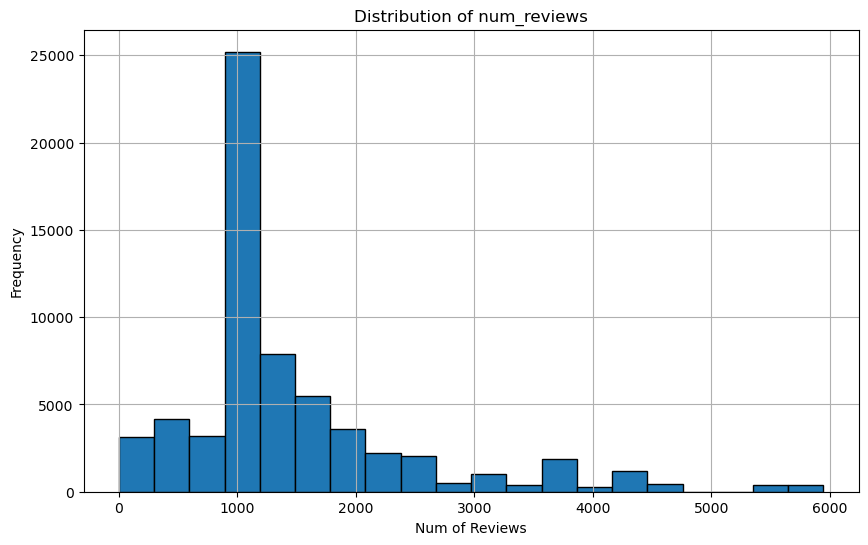

In [18]:
plt.figure(figsize=(10,6))
plt.hist(data['num_reviews'], bins=20, edgecolor='black')
plt.title('Distribution of num_reviews')
plt.xlabel('Num of Reviews')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## גרף ציונים

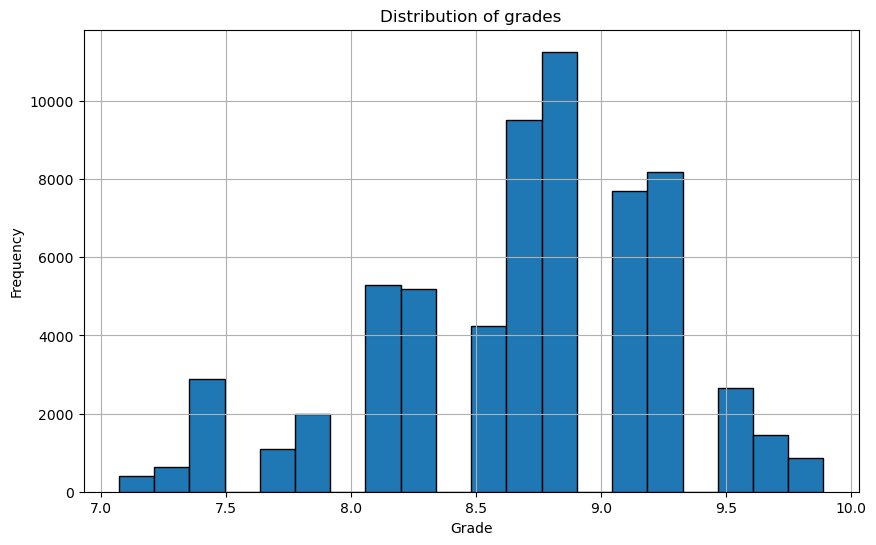

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(data['grade'], bins=20, edgecolor='black')
plt.title('Distribution of grades')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## גרף מחירים

### חילוק השכונות לפי מחיר ממוצע

## גרף מחירים

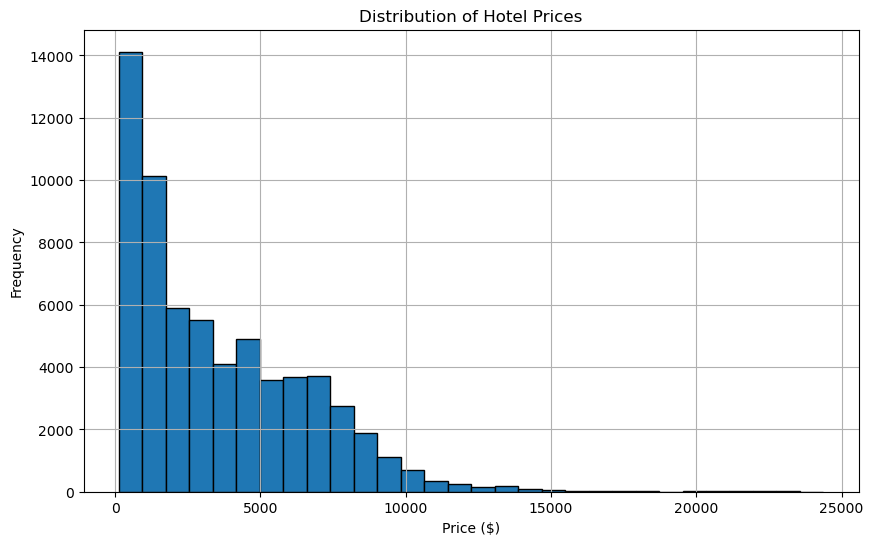

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(data['price'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Hotel Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## ביצוע outlier על פי שיטת Tukey ( IQR1.5 )

In [21]:
print(data['price'].dtype)

float64


In [22]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Determine the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
data_new = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

# Display the number of removed outliers
num_outliers = data.shape[0] - data_new.shape[0]
num_outliers

591

In [23]:
data=data_new
data

,name,neighborhood,current_price,reviews_desc,num_reviews,breakfast,free_cancellation,grade,fully_refundable,reserve_now_pay_later,price_after_taxes,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,price
1,Hyatt House Jersey City,Jersey City,227.0,Excellent,1306.0,Yes,No,8.68,No,No,265.0,2024-07-08,2024-07-09,1,1,2024-07-07,2,265.0
2,Margaritaville Resort Times Square,Theater District,185.0,Wonderful,3670.0,No,No,9.29,No,No,274.0,2024-07-08,2024-07-09,1,1,2024-07-07,3,274.0
3,Penny Williamsburg,Williamsburg,220.0,Exceptional,521.0,No,Yes,9.69,Yes,Yes,292.0,2024-07-08,2024-07-09,1,1,2024-07-07,4,292.0
4,"PUBLIC, an Ian Schrager hotel",New York,329.0,Very,2625.0,No,No,8.28,No,No,427.0,2024-07-08,2024-07-09,1,1,2024-07-07,5,427.0
5,Radio City Apartments,Theater District,127.0,Excellent,3586.0,No,No,8.88,No,No,150.0,2024-07-08,2024-07-09,1,1,2024-07-07,6,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67945,The Solita Soho Hotel,New York,170.0,Good,1004.0,No,Yes,7.87,Yes,No,1110.0,2024-08-04,2024-08-09,29,5,2024-07-06,151,5550.0
67946,"InterContinental New York Times Square, an IHG...",New York,300.0,Very,1068.0,No,No,8.48,No,No,1940.0,2024-08-04,2024-08-09,29,5,2024-07-06,152,9700.0
67947,Pestana CR7 Times Square,New York,194.0,Excellent,678.0,No,Yes,8.88,Yes,Yes,1265.0,2024-08-04,2024-08-09,29,5,2024-07-06,153,6325.0
67948,East Village Hotel,New York,203.0,Very,652.0,No,Yes,8.28,Yes,No,1302.0,2024-08-04,2024-08-09,29,5,2024-07-06,154,6510.0


# Data Manipulation

## טיפול בשדה "תיאור ציון" והמרתו לשדה של יחס סדר

In [24]:
unique_grades = data['reviews_desc'].unique()
unique_grades

array(['Excellent', 'Wonderful', 'Exceptional', 'Very', 'Good'],
      dtype=object)

In [25]:
data['reviews_desc'].value_counts()

reviews_desc
Excellent      20537
Wonderful      15732
Very           14704
Good            7002
Exceptional     4799
Name: count, dtype: int64

In [26]:
def get_average_grade_for_keywords(row, keyword):
    if pd.isna(row['reviews_desc']) or not isinstance(row['reviews_desc'], str):
        return None
    if keyword in row['reviews_desc']:
        return row['grade']
    return None

# Apply the function to get grades based on keywords
grades_by_keyword = []
for keyword in unique_grades:
    keyword_grades = data.apply(lambda row: get_average_grade_for_keywords(row, keyword), axis=1)
    keyword_grades = keyword_grades.dropna()
    if not keyword_grades.empty:
        avg_grade = keyword_grades.mean()
        grades_by_keyword.append((keyword, avg_grade))

# Sort keywords by average price
grades_by_keyword.sort(key=lambda x: x[1], reverse=True)
grades_by_keyword

[('Exceptional', 9.610500104188372),
 ('Wonderful', 9.192593440122042),
 ('Excellent', 8.788097579977602),
 ('Very', 8.265650163220894),
 ('Good', 7.574284490145673)]

In [27]:
keyword_priority = {keyword: 5 - idx for idx, (keyword, _) in enumerate(grades_by_keyword)}

# Ensure we have up to 5 priorities
for idx in range(len(keyword_priority), 5):
    keyword_priority[f'Other_{5 - idx}'] = 5 - idx

keyword_priority

{'Exceptional': 5, 'Wonderful': 4, 'Excellent': 3, 'Very': 2, 'Good': 1}

In [28]:
# Define a function to map room type to priority
def map_room_type_to_priority(reviews_desc):
    if isinstance(reviews_desc, (int, int)):  # Skip if already a number
        return reviews_desc
    if pd.isna(reviews_desc) or not isinstance(reviews_desc, str):
        return 0  # Default priority for NaN values or non-string types
    for keyword, priority in keyword_priority.items():
        if keyword in reviews_desc:
            return priority
    return 0  # Default priority for unlisted types

# Apply the mapping to the reviews_desc column using .loc to avoid SettingWithCopyWarning
data.loc[:, 'reviews_desc'] = data['reviews_desc'].apply(map_room_type_to_priority)

# Display the updated dataframe
data.head()

,name,neighborhood,current_price,reviews_desc,num_reviews,breakfast,free_cancellation,grade,fully_refundable,reserve_now_pay_later,price_after_taxes,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,price
1,Hyatt House Jersey City,Jersey City,227.0,3,1306.0,Yes,No,8.68,No,No,265.0,2024-07-08,2024-07-09,1,1,2024-07-07,2,265.0
2,Margaritaville Resort Times Square,Theater District,185.0,4,3670.0,No,No,9.29,No,No,274.0,2024-07-08,2024-07-09,1,1,2024-07-07,3,274.0
3,Penny Williamsburg,Williamsburg,220.0,5,521.0,No,Yes,9.69,Yes,Yes,292.0,2024-07-08,2024-07-09,1,1,2024-07-07,4,292.0
4,"PUBLIC, an Ian Schrager hotel",New York,329.0,2,2625.0,No,No,8.28,No,No,427.0,2024-07-08,2024-07-09,1,1,2024-07-07,5,427.0
5,Radio City Apartments,Theater District,127.0,3,3586.0,No,No,8.88,No,No,150.0,2024-07-08,2024-07-09,1,1,2024-07-07,6,150.0


In [29]:
data['reviews_desc'].value_counts()

reviews_desc
3    20537
4    15732
2    14704
1     7002
5     4799
Name: count, dtype: int64

## המרת משתנים בעלי אופי נומינלי או קטגורי באמצעות מספר עמודות


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62774 entries, 1 to 67949
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   62774 non-null  object        
 1   neighborhood           62774 non-null  object        
 2   current_price          62774 non-null  float64       
 3   reviews_desc           62774 non-null  object        
 4   num_reviews            62774 non-null  float64       
 5   breakfast              62774 non-null  object        
 6   free_cancellation      62774 non-null  object        
 7   grade                  62774 non-null  float64       
 8   fully_refundable       62774 non-null  object        
 9   reserve_now_pay_later  62774 non-null  object        
 10  price_after_taxes      62774 non-null  float64       
 11  checkin_date           62774 non-null  datetime64[ns]
 12  checkout_date          62774 non-null  datetime64[ns]
 13  TTT   

In [31]:
data['breakfast'].replace({'No':0,'Yes':1},inplace=True)
data['free_cancellation'].replace({'No':0,'Yes':1},inplace=True)
data['fully_refundable'].replace({'No':0,'Yes':1},inplace=True)
data['reserve_now_pay_later'].replace({'No':0,'Yes':1},inplace=True)

In [32]:
data.head()

,name,neighborhood,current_price,reviews_desc,num_reviews,breakfast,free_cancellation,grade,fully_refundable,reserve_now_pay_later,price_after_taxes,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,price
1,Hyatt House Jersey City,Jersey City,227.0,3,1306.0,1,0,8.68,0,0,265.0,2024-07-08,2024-07-09,1,1,2024-07-07,2,265.0
2,Margaritaville Resort Times Square,Theater District,185.0,4,3670.0,0,0,9.29,0,0,274.0,2024-07-08,2024-07-09,1,1,2024-07-07,3,274.0
3,Penny Williamsburg,Williamsburg,220.0,5,521.0,0,1,9.69,1,1,292.0,2024-07-08,2024-07-09,1,1,2024-07-07,4,292.0
4,"PUBLIC, an Ian Schrager hotel",New York,329.0,2,2625.0,0,0,8.28,0,0,427.0,2024-07-08,2024-07-09,1,1,2024-07-07,5,427.0
5,Radio City Apartments,Theater District,127.0,3,3586.0,0,0,8.88,0,0,150.0,2024-07-08,2024-07-09,1,1,2024-07-07,6,150.0


In [33]:
# בדיקת היקף הערכים של 1 והאם צריך להוריד את העמודה
data['breakfast'].value_counts()

breakfast
0    54587
1     8187
Name: count, dtype: int64

In [34]:
# בדיקת היקף הערכים של 1 והאם צריך להוריד את העמודה
data['free_cancellation'].value_counts()

free_cancellation
0    33378
1    29396
Name: count, dtype: int64

In [35]:
# בדיקת היקף הערכים של 1 והאם צריך להוריד את העמודה
data['fully_refundable'].value_counts()

fully_refundable
0    33378
1    29396
Name: count, dtype: int64

In [36]:
# בדיקת היקף הערכים של 1 והאם צריך להוריד את העמודה
data['reserve_now_pay_later'].value_counts()

reserve_now_pay_later
0    40897
1    21877
Name: count, dtype: int64

In [37]:
data = pd.get_dummies(data,columns=['neighborhood'])
data.columns

Index(['name', 'current_price', 'reviews_desc', 'num_reviews', 'breakfast',
       'free_cancellation', 'grade', 'fully_refundable',
       'reserve_now_pay_later', 'price_after_taxes', 'checkin_date',
       'checkout_date', 'TTT', 'LOS', 'Snapshot Date', 'order', 'price',
       'neighborhood_Bronx', 'neighborhood_Brooklyn',
       'neighborhood_Central New York City', 'neighborhood_Chelsea',
       'neighborhood_Downtown Brooklyn', 'neighborhood_Entire home',
       'neighborhood_Flushing', 'neighborhood_Greenwich Village',
       'neighborhood_Harlem', 'neighborhood_Jamaica',
       'neighborhood_Jersey City', 'neighborhood_Long Island City',
       'neighborhood_New York', 'neighborhood_Queens', 'neighborhood_SoHo',
       'neighborhood_Theater District', 'neighborhood_Upper West Side',
       'neighborhood_Williamsburg'],
      dtype='object')

In [38]:
data.columns

Index(['name', 'current_price', 'reviews_desc', 'num_reviews', 'breakfast',
       'free_cancellation', 'grade', 'fully_refundable',
       'reserve_now_pay_later', 'price_after_taxes', 'checkin_date',
       'checkout_date', 'TTT', 'LOS', 'Snapshot Date', 'order', 'price',
       'neighborhood_Bronx', 'neighborhood_Brooklyn',
       'neighborhood_Central New York City', 'neighborhood_Chelsea',
       'neighborhood_Downtown Brooklyn', 'neighborhood_Entire home',
       'neighborhood_Flushing', 'neighborhood_Greenwich Village',
       'neighborhood_Harlem', 'neighborhood_Jamaica',
       'neighborhood_Jersey City', 'neighborhood_Long Island City',
       'neighborhood_New York', 'neighborhood_Queens', 'neighborhood_SoHo',
       'neighborhood_Theater District', 'neighborhood_Upper West Side',
       'neighborhood_Williamsburg'],
      dtype='object')

# בחינת הנתונים

In [39]:
data.describe()

,current_price,num_reviews,breakfast,free_cancellation,grade,fully_refundable,reserve_now_pay_later,price_after_taxes,checkin_date,checkout_date,TTT,LOS,Snapshot Date,order,price
count,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774,62774,62774.000000,62774.000000,62774,62774.000000,62774.000000
mean,257.782410,1465.367588,0.130420,0.468283,8.694572,0.468283,0.348504,947.155399,2024-07-21 04:59:28.458278912,2024-07-24 04:26:51.265810688,15.206630,2.977347,2024-07-06 00:01:55.614745088,78.119970,3434.343422
min,70.000000,1.000000,0.000000,0.000000,7.070000,0.000000,0.000000,128.000000,2024-07-06 00:00:00,2024-07-07 00:00:00,0.000000,1.000000,2024-07-05 00:00:00,2.000000,128.000000
25%,211.000000,1002.000000,0.000000,0.000000,8.280000,0.000000,0.000000,531.000000,2024-07-14 00:00:00,2024-07-17 00:00:00,8.000000,2.000000,2024-07-05 00:00:00,40.000000,1036.000000
50%,242.000000,1060.000000,0.000000,0.000000,8.880000,0.000000,0.000000,909.000000,2024-07-21 00:00:00,2024-07-24 00:00:00,15.000000,3.000000,2024-07-06 00:00:00,78.000000,2685.000000
75%,284.000000,1651.000000,0.000000,1.000000,9.090000,1.000000,1.000000,1303.000000,2024-07-29 00:00:00,2024-08-01 00:00:00,23.000000,4.000000,2024-07-07 00:00:00,117.000000,5504.000000
max,1264.000000,5946.000000,1.000000,1.000000,9.890000,1.000000,1.000000,3668.000000,2024-08-06 00:00:00,2024-08-11 00:00:00,30.000000,5.000000,2024-07-07 00:00:00,155.000000,12460.000000
std,79.395227,1022.960264,0.336768,0.498997,0.576195,0.498997,0.476500,509.220807,NaN,NaN,8.652064,1.408512,NaN,43.797325,2835.527222


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62774 entries, 1 to 67949
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   name                                62774 non-null  object        
 1   current_price                       62774 non-null  float64       
 2   reviews_desc                        62774 non-null  object        
 3   num_reviews                         62774 non-null  float64       
 4   breakfast                           62774 non-null  int64         
 5   free_cancellation                   62774 non-null  int64         
 6   grade                               62774 non-null  float64       
 7   fully_refundable                    62774 non-null  int64         
 8   reserve_now_pay_later               62774 non-null  int64         
 9   price_after_taxes                   62774 non-null  float64       
 10  checkin_date               

In [41]:
# טעות בקלט - שכונה לא קיימת (יש שורה אחת)
data = data.drop(['neighborhood_Entire home'], axis=1)

In [42]:
corr_price = data[['current_price','reviews_desc','num_reviews','breakfast','free_cancellation','grade','fully_refundable','reserve_now_pay_later','price','TTT','LOS' ]].corr()['price']
corr_price.sort_values()

TTT                     -0.043819
breakfast               -0.031715
num_reviews              0.011688
grade                    0.074384
reviews_desc             0.081083
free_cancellation        0.099576
fully_refundable         0.099576
reserve_now_pay_later    0.118038
current_price            0.216131
LOS                      0.923537
price                    1.000000
Name: price, dtype: float64

In [43]:
corr_price_loc = data[['neighborhood_Bronx', 'neighborhood_Brooklyn', 'neighborhood_Central New York City' ,'neighborhood_Downtown Brooklyn', 'neighborhood_Chelsea', 'neighborhood_Flushing' , 'neighborhood_Harlem','neighborhood_Greenwich Village','neighborhood_Jamaica','neighborhood_Jersey City','neighborhood_Long Island City',  'neighborhood_New York','neighborhood_Queens' ,'neighborhood_SoHo', 'neighborhood_Theater District', 'neighborhood_Upper West Side' , 'neighborhood_Williamsburg','price']].corr()['price']
corr_price_loc.sort_values()

neighborhood_New York                -0.060909
neighborhood_Queens                  -0.042175
neighborhood_Long Island City        -0.020538
neighborhood_Brooklyn                -0.018603
neighborhood_Downtown Brooklyn       -0.013885
neighborhood_SoHo                    -0.013018
neighborhood_Greenwich Village       -0.009948
neighborhood_Flushing                -0.006931
neighborhood_Jersey City             -0.006255
neighborhood_Chelsea                 -0.003862
neighborhood_Bronx                   -0.003738
neighborhood_Jamaica                 -0.001413
neighborhood_Upper West Side          0.008490
neighborhood_Harlem                   0.014375
neighborhood_Williamsburg             0.017652
neighborhood_Central New York City    0.036555
neighborhood_Theater District         0.073102
price                                 1.000000
Name: price, dtype: float64

<Axes: >

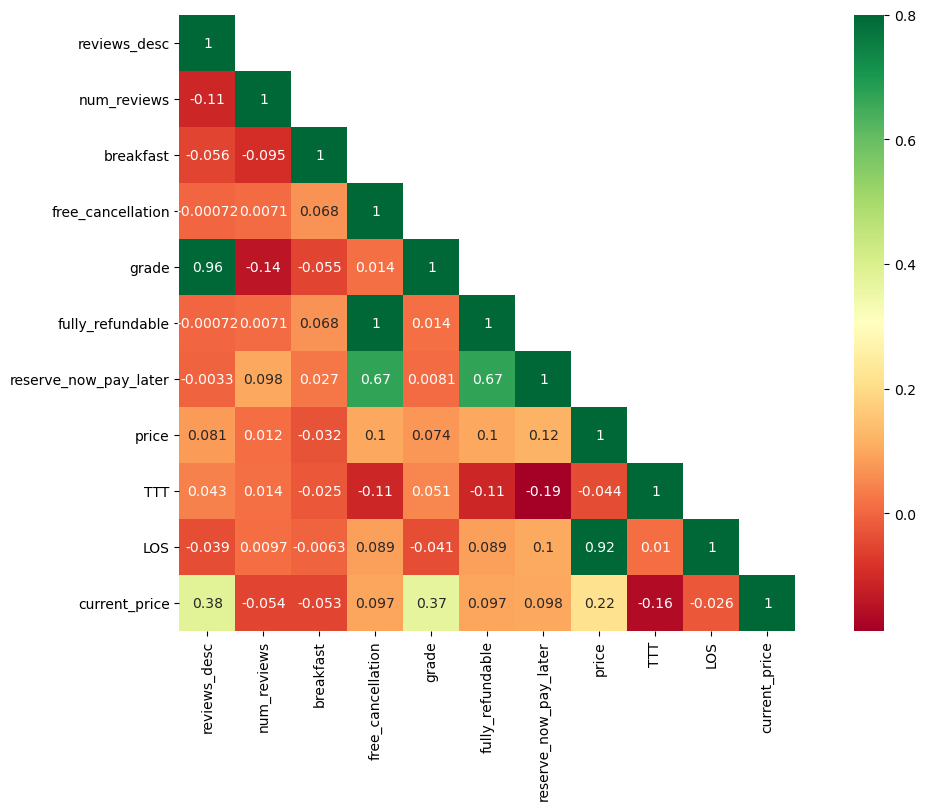

In [44]:
plt.figure(figsize=(15,8))
mask = np.array(data[['reviews_desc','num_reviews','breakfast','free_cancellation','grade','fully_refundable','reserve_now_pay_later','price','TTT','LOS', 'current_price' ]].corr())
mask[np.tril_indices_from(mask)] = False
sns.heatmap(data[['reviews_desc','num_reviews','breakfast','free_cancellation','grade','fully_refundable','reserve_now_pay_later','price','TTT','LOS', 'current_price' ]].corr(), annot=True, cmap='RdYlGn', mask=mask, vmax=0.8, square=True)

# Create the PairGrid

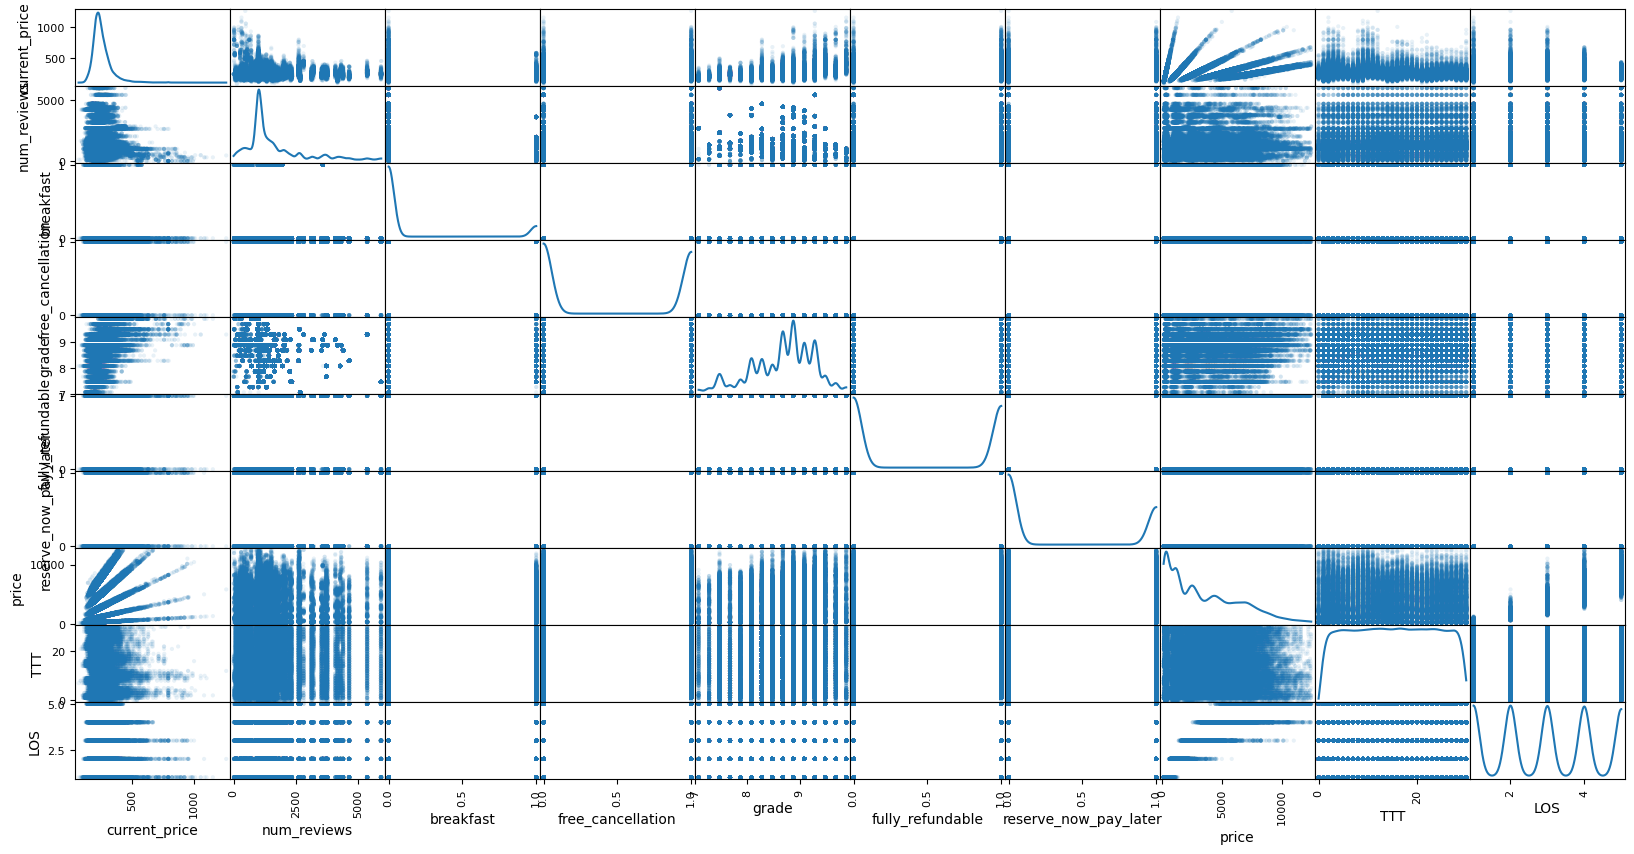

In [45]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[['current_price','reviews_desc','num_reviews','breakfast','free_cancellation','grade','fully_refundable','reserve_now_pay_later','price','TTT','LOS']], figsize=(20,10), alpha=0.1, diagonal='kde')
plt.show()

In [46]:
data.columns

Index(['name', 'current_price', 'reviews_desc', 'num_reviews', 'breakfast',
       'free_cancellation', 'grade', 'fully_refundable',
       'reserve_now_pay_later', 'price_after_taxes', 'checkin_date',
       'checkout_date', 'TTT', 'LOS', 'Snapshot Date', 'order', 'price',
       'neighborhood_Bronx', 'neighborhood_Brooklyn',
       'neighborhood_Central New York City', 'neighborhood_Chelsea',
       'neighborhood_Downtown Brooklyn', 'neighborhood_Flushing',
       'neighborhood_Greenwich Village', 'neighborhood_Harlem',
       'neighborhood_Jamaica', 'neighborhood_Jersey City',
       'neighborhood_Long Island City', 'neighborhood_New York',
       'neighborhood_Queens', 'neighborhood_SoHo',
       'neighborhood_Theater District', 'neighborhood_Upper West Side',
       'neighborhood_Williamsburg'],
      dtype='object')

# תובנות מהגרפים

In [47]:
# שמירת הנתונים לקובץ CSV
data.to_csv('expedia_data.csv', index=False)